In [1]:
#导入内部数据集，
from torchvision import datasets,transforms
'''
CIFAR-10是kaggle计算机视觉竞赛的一个图像分类项目。
该数据集共有60000张32*32彩色图像，一共可以分为"plane", “car”, “bird”,“cat”, “deer”, “dog”, “frog”,“horse”,“ship”, “truck” 10类，
每类6000张图。有50000张用于训练，构成了5个训练批，每一批10000张图；10000张用于测试，单独构成一批。

'''
#引入相应的包
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as func
import PIL.ImageOps
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#定义hyper-parameter
num_epochs = 5
num_classes = 10
batch_size = 32
learning_rate = 0.001

In [3]:
tarnsform_fun=transforms.Compose([transforms.Pad(4),transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
#一般用Compose把多个步骤整合到一起
#1.缩放图片，变成32*32
#2.归一化至0-1
#3.归一化到-1，1``input[channel] = (input[channel] - mean[channel]) / std[channel]``
training_data=datasets.CIFAR10(root='./data',train=True,download=True,transform=tarnsform_fun)

validation_data=datasets.CIFAR10(root='./data',train=False,download=True,transform=tarnsform_fun)
train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=validation_data, batch_size=batch_size, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
print(training_data)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Pad(padding=4, fill=0, padding_mode=constant)
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


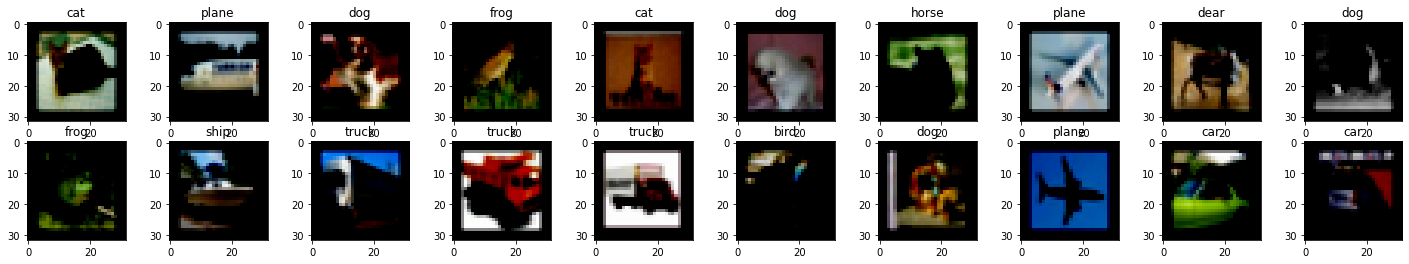

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'dear', 'dog', 'frog', 'horse', 'ship', 'truck')

def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    print(image.shape)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1)
    return image
dataiter = iter(train_loader)#迭代器
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1)
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [8]:
print(images[0].shape)

torch.Size([3, 32, 32])


In [9]:
# 两个卷积层

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            # 卷积层计算
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            #  批归一化
            nn.BatchNorm2d(16),
            #ReLU激活函数
            nn.ReLU(),
            # 池化层：最大池化
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Linear(8*8*32, num_classes)
        
    # 定义前向传播顺序
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
#引进cpu或者gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [11]:
#实例化模型
model = CNN(num_classes).to(device)

In [12]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
'''
交叉熵主要是用来判定实际的输出与期望的输出的接近程度，为什么这么说呢，
举个例子：在做分类的训练的时候，如果一个样本属于第K类，那么这个类别所对应的的输出节点的输出值应该为1，
而其他节点的输出都为0，即[0,0,1,0,….0,0]，这个数组也就是样本的Label，
是神经网络最期望的输出结果。也就是说用它来衡量网络的输出与标签的差异，利用这种差异经过反向传播去更新网络参数。
'''
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
total_step = len(train_loader)
loss_history = []
correct_history = []
val_loss_history = []
val_correct_history = []
total_step = len(train_loader)
for epoch in range(num_epochs):
  _loss=0.0
  _correct=0.0
  test_loss=0.0
  _total=0
  test_correct=0.0
  for i, (images, labels) in enumerate(train_loader):
        # 注意模型在GPU中，数据也要搬到GPU中
        images = images.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #累计每一轮epoch的损失
        _,preds=torch.max(outputs.data,1)
        _correct+= (preds == labels).sum().item()
        _loss+=loss.item()
        _total += labels.size(0)
  print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
  loss_history.append(_loss/_total)
  correct_history.append(_correct/_total)
  # 节省计算资源，不去计算梯度
  with torch.no_grad():
      correct = 0
      total = 0
      lossx=0.0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          lossx+=loss.item()
          correct += (predicted == labels).sum().item()
      val_loss_history.append(lossx/total)
      val_correct_history.append(correct/total)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/5], Step [1563/1563], Loss: 1.3232
Epoch [2/5], Step [1563/1563], Loss: 0.9646
Epoch [3/5], Step [1563/1563], Loss: 0.6228
Epoch [4/5], Step [1563/1563], Loss: 1.7803
Epoch [5/5], Step [1563/1563], Loss: 0.7894


In [ ]:
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

2931.581330537796 tensor(16263., device='cuda:0')


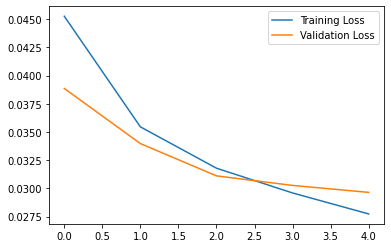

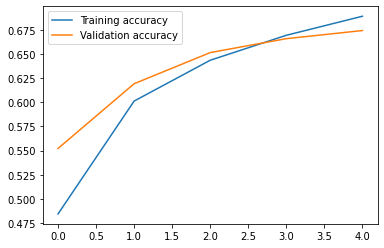

In [14]:
#可视化
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.show()
plt.plot(correct_history, label='Training accuracy')
plt.plot(val_correct_history, label='Validation accuracy')
plt.legend()
plt.show()

In [ ]:
## 模型正确率很低，开始进行相应的调整



### 模型正确率很低，开始进行相应的调整
#### 1.调整学习率
通过分析，训练过程中有过拟合的迹象，学习率可能过高，因此，调整学习率至0.001，调整学习率后，重新训练，评估模型


In [14]:
learning_rate = 0.001


#### 2.调整学网络结构
增加卷积网络层数，可便于神经网络更好的提取特征，将网络层数由两层增加为3层。


In [14]:
# 3个卷积层

class CNNpro(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNpro, self).__init__()
        self.conv1 = nn.Sequential(
            # 卷积层计算
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            #  批归一化
            nn.BatchNorm2d(16),
            #ReLU激活函数
            nn.ReLU(),
            # 池化层：最大池化
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.fc = nn.Linear(4*4*64, num_classes)
        
    # 定义前向传播顺序
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [15]:
# 定义损失函数和优化器
model = CNNpro(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
'''
交叉熵主要是用来判定实际的输出与期望的输出的接近程度，为什么这么说呢，
举个例子：在做分类的训练的时候，如果一个样本属于第K类，那么这个类别所对应的的输出节点的输出值应该为1，
而其他节点的输出都为0，即[0,0,1,0,….0,0]，这个数组也就是样本的Label，
是神经网络最期望的输出结果。也就是说用它来衡量网络的输出与标签的差异，利用这种差异经过反向传播去更新网络参数。
'''
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
total_step = len(train_loader)
loss_history = []
correct_history = []
val_loss_history = []
val_correct_history = []
total_step = len(train_loader)
for epoch in range(num_epochs):
  _loss=0.0
  _correct=0.0
  test_loss=0.0
  _total=0
  test_correct=0.0
  for i, (images, labels) in enumerate(train_loader):
        # 注意模型在GPU中，数据也要搬到GPU中
        images = images.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #累计每一轮epoch的损失
        _,preds=torch.max(outputs.data,1)
        _correct+= (preds == labels).sum().item()
        _loss+=loss.item()
        _total += labels.size(0)
  print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
  loss_history.append(_loss/_total)
  correct_history.append(_correct/_total)
  # 节省计算资源，不去计算梯度
  with torch.no_grad():
      correct = 0
      total = 0
      lossx=0.0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          lossx+=loss.item()
          correct += (predicted == labels).sum().item()
      val_loss_history.append(lossx/total)
      val_correct_history.append(correct/total)


Epoch [1/5], Step [1563/1563], Loss: 1.1521
Epoch [2/5], Step [1563/1563], Loss: 1.5423
Epoch [3/5], Step [1563/1563], Loss: 0.9828
Epoch [4/5], Step [1563/1563], Loss: 0.9016
Epoch [5/5], Step [1563/1563], Loss: 0.8433


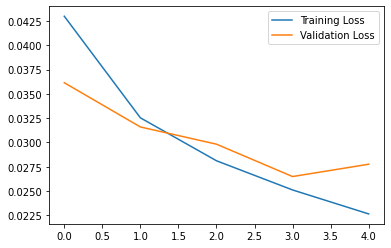

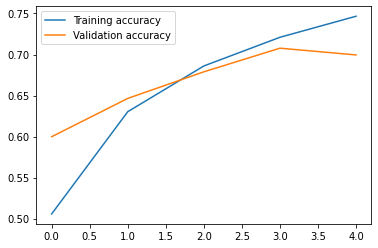

In [17]:
#可视化
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.show()
plt.plot(correct_history, label='Training accuracy')
plt.plot(val_correct_history, label='Validation accuracy')
plt.legend()
plt.show()

In [18]:
#  保存模型
torch.save(model.state_dict(), 'model.ckpt')